In [1]:
# for numbers
import xarray as xr
import numpy as np
import pandas as pd

# for figures
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from numba import jit, prange

In [2]:
# An "anonymous function" to print the max value of an Xarray DataArray
printMax = lambda x: print(np.asscalar(x.max().values))

In [3]:
def quick_map(lons, lats, data, title=None, **kwargs):
    f, a = plt.subplots(subplot_kw={"projection":ccrs.Robinson()})
    # pass in norm as kwarg if needed
    # norm = mpl.colors.Normalize(vmin=1979, vmax=2019)
    img = a.pcolormesh(lons, lats, data, transform=ccrs.PlateCarree(), **kwargs)
    a.set_title(title)
    f.colorbar(img, shrink=0.4)
    return f, a

In [4]:
# Sligthly fancier way:
# from pathlib import Path
# stem = Path("/project/amp/brianpm/TemperatureExtremes/Derived")
# fil = "CPC_tmax_90pct_event_attributes_compressed.nc"
# ds = xr.open_dataset(stem/fil)

# Slightly easier way:
stem = "/project/amp/brianpm/TemperatureExtremes/Derived/"
fil = "CPC_tmax_90pct_event_attributes_compressed.nc"
ds = xr.open_dataset(stem+fil)

In [5]:
print("DataSet Information")
print(f"Dimensions {ds.dims}")
print(f"Variables: {ds.data_vars}")

DataSet Information
Dimensions Frozen(SortedKeysDict({'events': 1202, 'lat': 360, 'lon': 720}))
Variables: Data variables:
    Event_ID       (events, lat, lon) float64 ...
    initial_index  (events, lat, lon) float64 ...
    duration       (events, lat, lon) float64 ...


In [6]:
ids = ds['Event_ID']  # each point has a series of events that are labeled as increasing integers
d = ds['duration']  # NOTE: the 1st entry in duration, i.e., d[0,:,:], is the number of zeros counted, so is number of non-event days.
init = ds['initial_index'].astype(int)  # the index value of `time` dimension from original data. One value per event gives the first day of the event.

In [7]:
# get dimensions out, set up lons, lats meshgrid for plots
# nlat and nlon are used later for indexing
lon = ds['lon']
lat = ds['lat']
nlat = len(ds['lat'])
nlon = len(ds['lon'])
lons, lats = np.meshgrid(lon, lat)

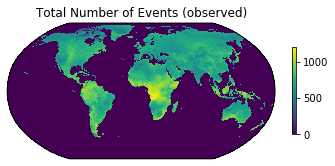

In [8]:
fig001, ax001 = plt.subplots(subplot_kw={"projection":ccrs.Robinson()})
img001 = ax001.pcolormesh(lons, lats, ids.max(dim='events'), transform=ccrs.PlateCarree())
ax001.set_title("Total Number of Events (observed)")
fig001.colorbar(img001, shrink=0.4)

In [9]:
# Use boulder as a test example
boulder = ds.sel(lat=40, lon=360-105, method='nearest')
# 
boulder

<xarray.Dataset>
Dimensions:        (events: 1202)
Coordinates:
  * events         (events) int64 1 2 3 4 5 6 ... 1197 1198 1199 1200 1201 1202
    lat            float64 40.25
    lon            float64 255.2
Data variables:
    Event_ID       (events) float64 0.0 1.0 2.0 3.0 4.0 ... 0.0 0.0 0.0 0.0 0.0
    initial_index  (events) float64 0.0 216.0 280.0 349.0 ... 0.0 0.0 0.0 0.0
    duration       (events) float64 ...

In [10]:
boulder['duration'].max().values

array(13297.)

In [11]:
printMax(boulder['duration'][1:])

9.0


# Duration
Make a map of the longest event at each location.

In [12]:
# define the longest event at each location
# skip the 0th element because there are always mostly "non-events"
d_longest = d[1:, :, :].max(dim='events')

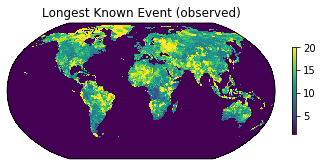

In [13]:
fig002, ax002 = plt.subplots(subplot_kw={"projection":ccrs.Robinson()})
norm = mpl.colors.Normalize(vmin=1, vmax=20)
img002 = ax002.pcolormesh(lons, lats, d_longest, transform=ccrs.PlateCarree(), norm=norm)
ax002.set_title("Longest Known Event (observed)")
fig002.colorbar(img002, shrink=0.4)

# Going back to time

We use `initial_index` to figure out when each event happens.

The `initial_index` is the position from the original data set. This is fragile because it depends on being able to re-load the exact same data in order to get correct times.

(To-Do: Brian should change the script to return the `time since <reference date>` in the file. That would make it much easier to deal with here.)

For now, we deal with it, and make a map of the year in which the longest event occurred. Of course, for many locations there will be ties, so we get more than one event. For now, we just take the first one.  This choice makes sense, but would be more justified if we also were breaking things down by season or month.

In [14]:
init

<xarray.DataArray 'initial_index' (events: 1202, lat: 360, lon: 720)>
array([[[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       ...,

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]],

       [[0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0],
        ...,
        [0, 0, ..., 0, 0],
        [0, 0, ..., 0, 0]]])
Coordinates:
  * events   (events) int64 1 2 3 4 5 6 7 ... 1196 1197 1198 1199 1200 1201 1202
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 0.25 0.75 1.25 1.75 2.25 ... 358.2 358.8 359.2 359.8

In [15]:
# Go back to the original data, but we don't need the actual values here,
# just the time coordinate
ds_orig = xr.open_mfdataset("/project/amp/jcaron/CPC_Tminmax/tmax*.nc", combine="by_coords")
t = ds_orig['time']

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [16]:
# Use boulder as our testing example
b_lg = np.where( boulder['duration'][1:] == boulder['duration'][1:].max(), 1, 0 )
longest_ndx = np.argwhere((boulder['duration'][1:] == boulder['duration'][1:].max()).values)
boulder_longest_initial_time = boulder['initial_index'][np.asscalar(longest_ndx)+1]
print(boulder_longest_initial_time)
t[int(np.asscalar(boulder_longest_initial_time.values))]

<xarray.DataArray 'initial_index' ()>
array(14497.)
Coordinates:
    events   int64 853
    lat      float64 40.25
    lon      float64 255.2


<xarray.DataArray 'time' ()>
array('2018-09-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2018-09-10
Attributes:
    long_name:           Time
    axis:                T
    standard_name:       time
    coordinate_defines:  start
    delta_t:             0000-00-01 00:00:00
    avg_period:          0000-00-01 00:00:00

In [17]:
# Apply similar approach for the whole data set
ndx_long = np.zeros((nlat, nlon))  # basically allocating memory
dv = d.values  # duration data, but converted from Xarray DataArray to numpy array
iv = init.values  # initial index data, as numpy array

# Loop over latitude (print), loop over longitude
# check if the longest duration event is zero (ocean in obs), skip if yes
# otherwise use np.argwhere() to get indices where duration == longest at that location 
# IF ties (i.e., multiple events with same longest duration), take the first one (.min())
# put the time index into ndx_long[i, j]
for i in range(nlat):
    print(f"working on latitude {ds['lat'][i].values}")
    for j in range(nlon):
        if d_longest[i, j] == 0:
            ndx_long[i, j] = np.nan
        else:
            longest_ndx = np.argwhere(dv[1:, i, j] == d_longest[i,j].values).min()
            if np.isnan(longest_ndx):
                print(f"checking on point {(i, j)} ---> the value we get is {longest_ndx} (add one)")
                break
            ndx_long[i,j] = iv[longest_ndx+1, i, j]


working on latitude 89.75
working on latitude 89.25
working on latitude 88.75
working on latitude 88.25
working on latitude 87.75
working on latitude 87.25
working on latitude 86.75
working on latitude 86.25
working on latitude 85.75
working on latitude 85.25
working on latitude 84.75
working on latitude 84.25
working on latitude 83.75
working on latitude 83.25
working on latitude 82.75
working on latitude 82.25
working on latitude 81.75
working on latitude 81.25
working on latitude 80.75
working on latitude 80.25
working on latitude 79.75
working on latitude 79.25
working on latitude 78.75
working on latitude 78.25
working on latitude 77.75
working on latitude 77.25
working on latitude 76.75
working on latitude 76.25
working on latitude 75.75
working on latitude 75.25
working on latitude 74.75
working on latitude 74.25
working on latitude 73.75
working on latitude 73.25
working on latitude 72.75
working on latitude 72.25
working on latitude 71.75
working on latitude 71.25
working on l

In [21]:
y = np.zeros((nlat,nlon))  # initial a year array

# loop over lat, lon (again!?!?!)
for i in range(nlat):
#     print(f"working on latitude {ds['lat'][i].values}")
    for j in range(nlon):
        tmp = ndx_long[i,j]
        if not np.isnan(tmp):
            y[i,j] = t[int(tmp)].dt.year  # go get the year of this time index, put it in y

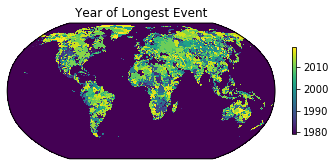

In [22]:
norm = mpl.colors.Normalize(vmin=1979, vmax=2019)
fig003a, ax003a = quick_map(lons, lats, y, title="Year of Longest Event", **{'norm':norm})

# Frequency

How often do events occur?

The first thing to do is figure out the average number of events per year.


In [23]:
# go back to our original detection file:
ds_events = xr.open_dataset(stem+"CPC_tmax_90pct_event_detection.nc")
events = ds_events['Event_ID']  # [time, lat, lon], data is the same event id as above, but now with the values repeated identifying the whole event.

In [24]:
# There are a few ways we could do this.
# One is just to count the number of days that qualify in each year. Probably not a great definition, but let's take a look.

event_binary_np = np.where(events.values > 0, 1, 0)
event_binary = xr.DataArray(event_binary_np, coords=events.coords, dims=events.dims)

num_per_year = event_binary.groupby('time.year').sum(dim='time') # ['year', lat, lon]


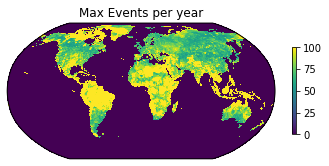

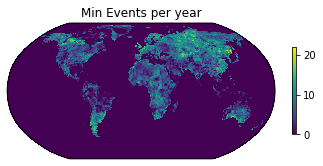

In [25]:
# look at the minimum and maximum
norm = mpl.colors.Normalize(vmin=0, vmax=100)
fig004a, ax004a = quick_map(lons, lats, num_per_year.max(dim='year'), title="Max Events per year", **{'norm':norm}) 
fig004b, ax004b = quick_map(lons, lats, num_per_year.min(dim='year'), title="Min Events per year") 

In [26]:
# probably it makes more sense to take a look at the average number of events per year
events_a = np.where(events.values > 0, events.values, np.nan)  # exclude zeros
events_a = xr.DataArray(events_a, coords=events.coords, dims=events.dims)
first_event_each_year = events_a.groupby('time.year').min(dim='time')
last_event_each_year = events_a.groupby('time.year').max(dim='time')
events_per_year = (last_event_each_year - first_event_each_year)+1  # ['year', lat, lon]
avg_events_per_year = events_per_year.mean(dim='year')


/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


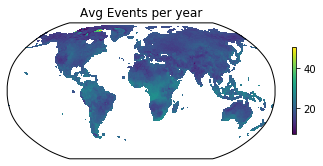

In [27]:
f005, a005 = quick_map(lons, lats, avg_events_per_year, title='Avg Events per year')

# Doing something by month

Since we probably care about Tmax extremes during summer more than winter.

We show how to do this for a single location (Boulder). 

It seems a little more complicated for the full dataset (partly because of different number of events at each location). But we can make summary statistics as needed, even if it requires a little bit of acrobatics.

In [28]:
amonth = events_a.isel(time=(events_a['time.month'] == 8))
yearly_first = amonth.groupby('time.year').min(dim='time')
yearly_last = amonth.groupby('time.year').max(dim='time')
year_num = (yearly_last - yearly_first)+1

/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


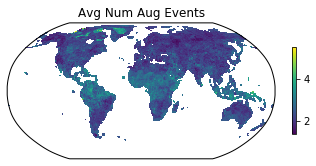

In [29]:
faug, aaug = quick_map(lons, lats, year_num.mean(dim='year'), title="Avg Num Aug Events")

In [30]:
# avg duration of august events

# could
# 1. extract august events from detections (use amonth) and derive duration
# 2. use duration from attributes, back out august events

In [31]:
# Try to start again with Boulder // # How long are august events in boulder

# init = ds['initial_index']
# time is t
z = boulder['initial_index'].astype(int)  # start times of the events (as integers)
zz = t[z.max()].values # date of last event // not needed
boulder_times = t[z[z != 0]]  # makes an xarray dataarray of datetime objects
# how many events in boulder
print(boulder['Event_ID'].max())
print(len(boulder_times))

<xarray.DataArray 'Event_ID' ()>
array(863.)
Coordinates:
    lat      float64 40.25
    lon      float64 255.2
863


In [32]:
bd = boulder['duration'][z != 0]  # use the same indices to extract the series of durations for boulder events
# longest boulder event
# boulder['duration'][z != 0].max()

# boulder - duration - august only:
bd_aug = bd[boulder_times['time.month'] == 8]
# average duration of august events in boulder
print(f"Average duration of august events in boulder: {bd_aug.mean().values} days")

# the actual dates of the august events
boulder_aug_events = boulder_times[ boulder_times['time.month'] == 8 ]


Average duration of august events in boulder: 1.662162162162162 days


In [33]:
boulder_aug_events['time.year']  # with a series of datetimes we can do things like get the year/month/day

<xarray.DataArray 'year' (events: 74)>
array([1979, 1980, 1981, 1981, 1985, 1985, 1986, 1986, 1987, 1987, 1987, 1988,
       1988, 1990, 1991, 1992, 1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996,
       2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2002, 2002, 2003, 2003,
       2003, 2003, 2004, 2005, 2005, 2006, 2006, 2007, 2007, 2007, 2007, 2008,
       2009, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011, 2012, 2012, 2012,
       2012, 2012, 2013, 2013, 2015, 2015, 2015, 2016, 2016, 2016, 2017, 2018,
       2018, 2018])
Coordinates:
    time     (events) datetime64[ns] 1979-08-05 1980-08-07 ... 2018-08-30
  * events   (events) int64 2 6 35 36 81 82 106 ... 771 772 773 810 850 851 852
    lat      float64 40.25
    lon      float64 255.2

In [34]:
xt = t[z[z != 0]]
xt['time.year']

<xarray.DataArray 'year' (events: 863)>
array([1979, 1979, 1979, ..., 2019, 2019, 2019])
Coordinates:
    time     (events) datetime64[ns] 1979-08-05 1979-10-08 ... 2019-04-26
  * events   (events) int64 2 3 4 5 6 7 8 9 ... 857 858 859 860 861 862 863 864
    lat      float64 40.25
    lon      float64 255.2

In [32]:
def loc_times(xy, time):
    a = time[xy[xy != 0]]
    return np.where(xy == 0, np.nan, a)




In [33]:
# now the trick is to apply the same approach to the multi-dimensional array
# make an array of datetime objects

# worst case, just loop through all points.

# say we want to get the number of events in each month.

# easiest way is probably to go through the event detection data, then:
# iyrs = set(events_a.time.dt.year.values)


# THIS IS FINE, BUT DOES NOT SOLVE THE PROBLEM OF GETTING DURATION YET.
# need to have pandas imported
dates = []
for year in range(1979, 2019):
    for month in range(1,13):
        dstr = f"{year}-{month:02d}"
        dates.append(pd.to_datetime(f"{year}-{month:02d}"))
        # print(f"shape for {dstr} is {events_a.sel(time=dstr).shape}")
        tmp = events_a.sel(time=dstr)
        n = tmp.max(dim='time') - tmp.min(dim='time')
        try:
            monthly_events = xr.concat([monthly_events, n], dim='time')
        except:
            print(n)
            monthly_events = n
            
# put in the time values            
monthly_events['time'] = dates       

<xarray.DataArray (lat: 360, lon: 720)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75


In [34]:
monthly_events

<xarray.DataArray (time: 480, lat: 360, lon: 720)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 0.25 0.75 1.25 1.75 ... 358.25 358.75 359.25 359.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01

In [35]:
aug_evnts = monthly_events[monthly_events['time.month']==8, : ,:].mean(dim='time')

/project/amp/brianpm/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


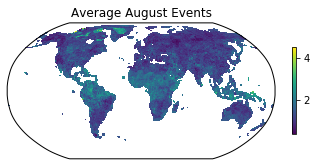

In [36]:
faug, aaug = quick_map(lons, lats, aug_evnts, title="Average August Events")

In [41]:
# if you need to build a variable within a loop, here's one option

for i in range(4):
    try:
        homer += "!"
    except:
        homer = "D'oh"
    
print(homer)

D'oh!!!!!!!!!!!


# Notes

We have three data sources that we can use:
- original data set Tmax(time, lat, lon)
- event detection Event_IDs(time, lat, lon)
- event attributes (ID, duration, index)(event, lat, lon)

One thing we could consider to make things easier is to revise the event attributes to also include a better representation of the time of the event. In particular, we should get the time value from the original data set (with units of days since a reference date).

The hard thing to do right now is to extract event duration (and amplitude) based on time. Part of the issue is that events at different locations happen at different times, so it isn't like "get event X based on it's time" unless it is at a given location. In our event detection, we can do say, "get all events in some time window", but then we need to figure out their duration. This is probably the way to do this though. 

To do that, we go use the event detection data, determine the values in the time selection, which are the IDs. Use those IDs to get the duration of those events.

In [36]:
# OK ... here's how we do it.
# This takes a little while. Partly because we do 2 loops over all space points.

# 1. Start by making events a "stacked" array, so that it looks 2D. (z is "space" dimension)
ev = events_a.stack(z=("lat", "lon")) # (time, z)


# 2. get our event ids from ev based on whatever time sampling we want
# For example, let's get all august events
ev_aug = ev[ev['time.month'] == 8, :]  # (time*, z), time* is only the times in august


In [37]:
# STEPS 3-5 are now handled in Numba functions, see next.

# IF YOU DON'T HAVE (OR CAN'T USE) NUMBA, UNCOMMENT THE FOLLOWING CODE (it works).

# # 3. get the event ids at each spatial point, put those into a new array of arrays (space x variable-length)
# ev_ids_to_get = np.empty(len(ev['z']), dtype=np.ndarray)
# for i,v in enumerate(ev_aug['z']): # v will be the tuple of (lat, lon)
#     ev_ids_to_get[i] = np.array( np.unique(ev_aug[:, i]) )  # the unique values (event IDs) at each space point.

# # 4. now we go back to our attributes to retrieve those events at each point
# # 4.a stack the attributes
# ds_stack = ds.stack(z=('lat', 'lon'))
# # 4.b create another array that will hold the durations for the selected events:
# ev_dur = np.empty(len(ev['z']), dtype=np.ndarray)
# # 4.c fill ev_dur with the duration values
# for i,v in enumerate(ev_ids_to_get):
#     if len(v) > 1:
#         ev_dur[i] = ds_stack['duration'][np.isin(ds_stack['Event_ID'][:,i], ev_ids_to_get[i]), i]
#     else:
#         ev_dur[i] = np.nan
        
# # 5. Now you have to do something with the durations. For now, we can just take the average.
# #    ev_dur is an array of arrays, so we have to do something to apply a function over each array within our array:
# mean_dur = np.array([i.mean() for i in ev_dur])

# # 6. We can no re-package mean_dur as a DataArray, unstack it, and map it:
# mean_dur_xr = xr.DataArray(mean_dur, coords={"z":ds_stack["z"]}, dims=("z",)).unstack()

# f007, a007 = quick_map(lons, lats, mean_dur_xr, title="Mean August Duration")

In [38]:
# Numba is a "just-in-time" compilation for python.
# In theory, it provides a way to speed up python calculations,
# both by compiling the calculation directly and also by allowing parallel execution.
# There is definitely some cost/pain to doing this because Numba is finnicky about everything.
# The only reason I think it might be worth it is because we seem to be doing a lot
# of loops over all locations, and that is very slow, but can be parallelized.

# If we know we want to do a simple operation, we can combine the loops
# Try to parallelize the loops with Numba (but have to just have np arrays then )

# a = ev (time, space)
# b = ev_aug (time*, space)
# c = ds_stack['duration'] (event, space)
# d = ds_stack['Event_ID'] (event, space)


# reinvent numpy.isin(). All we need are the indices where a value matches.
# we can use np.nonzero -- return the indices of the elements that are nonzero
# we can also use where
# @njit
# def my_isin(arr, test_elements):
#     separate = [np.asarray(arr == el).nonzero()[0] for el in test_elements] # note [0] to get the first element of tuple, which is array
#     result = []
#     result = [result.append(s) for s in separate]
#     return np.sort( np.array(result))
# I could not get this to compile, but I boiled it down to the basics in the version below.


# EXAMPLE of a Numba function that will at least work:
@jit
def my_nothing(foo, bar):
    result = []
    for i in foo:
        result.append(i)
    for j in bar:
        result.append(j)
    return result



@jit
def my_isin(arr, test_elements):
    asiz = arr.shape[0]
    result = []
    for i in range(asiz):
        a = arr[i]
        for b in test_elements:
            if a == b:
                result.append(i)
    return sorted(result)
            


@jit(nopython=True, parallel=True)
def get_vals(a, b, c, d):
    s = a.shape
    out = np.empty(s[1])  # just space -- Numba can't deal with "ragged" arrays
    for i in prange(s[1]):
        temp1 = np.unique(b[:, i])
        if len(temp1) > 1:
            temp2a = my_isin(d[:,i], temp1) # returns a list of indices
            # numba wont' let me index with a list, so we have to break it down:
            tmp2b = [c[j, i] for j in temp2a] # makes a list of values from 'c'
            tmp2c = 0
            for k in tmp2b:
                tmp2c += k
            out[i] = tmp2c / len(tmp2b)
#             out[i] = temp2.mean()
        else:
            out[i] = np.nan 
    return out

In [40]:
ds_stack = ds.stack(z=("lat","lon"))
evalues = ds_stack['Event_ID'].values
dvalues = ds_stack['duration'].values

In [53]:
%%time
# get_valus should produce an array with spatial dimension "z" 
tmptry_aug = get_vals(ev.values, ev_aug.values, dvalues, evalues)
# that means we can re-wrap it:


CPU times: user 17min 4s, sys: 1.01 s, total: 17min 5s
Wall time: 14.6 s


In [57]:
%%time
# Example with another month.
# This should be even faster to execute than the first one because no additional compilation should be required.
ev_jan = ev[ev['time.month'] == 1, :]  # (time*, z), time* is only the times in august
tmptry_jan = get_vals(ev.values, ev_jan.values, dvalues, evalues)
# note, in Jupyter notebook, it did not appear that the line after this was evaluated, so moved to next cell.

CPU times: user 425 ms, sys: 499 ms, total: 924 ms
Wall time: 922 ms


In [80]:
%%time
# Example with another month.
# This should be even faster to execute than the first one because no additional compilation should be required.
ev_feb = ev[ev['time.month'] == 2, :]  # (time*, z), time* is only the times in august
tmptry_feb = get_vals(ev.values, ev_feb.values, dvalues, evalues)

CPU times: user 384 ms, sys: 455 ms, total: 839 ms
Wall time: 837 ms


In [84]:
tmptry_feb

NameError: name 'tmptry_feb' is not defined

In [83]:

# 6. We can no re-package mean_dur as a DataArray, unstack it, and map it:
mean_dur_aug = xr.DataArray(tmptry_aug, coords={"z":ds_stack["z"]}, dims=("z",)).unstack()

mean_dur_jan = xr.DataArray(tmptry_jan, coords={"z":ds_stack["z"]}, dims=("z",)).unstack()

NameError: name 'tmptry_jan' is not defined

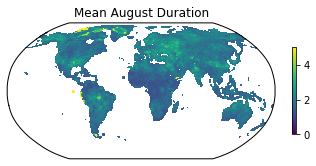

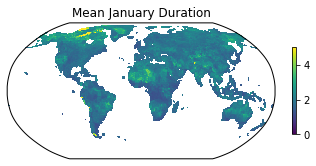

In [62]:
norm = mpl.colors.Normalize(vmin=0, vmax=5)
f007, a007 = quick_map(lons, lats, mean_dur_aug, title="Mean August Duration", **{'norm':norm})
f008, a008 = quick_map(lons, lats, mean_dur_jan, title="Mean January Duration", **{'norm':norm})

In [216]:
r = np.empty(5, dtype=np.ndarray)

for i, v in enumerate(r.ravel()):
    r[i] = np.array([1]*np.random.randint(low=2, high=10)) # random length list turned into an array

In [48]:
tmptry

array([nan, nan, nan, ..., nan, nan, nan])

In [127]:
@njit
def arr_of_arr(siz):
    r = np.empty(siz)
    for i in prange(siz):
        r[i] = np.array([1]*np.random.randint(low=2, high=10)) # random length list turned into an array
    return r

In [128]:
arr_of_arr(5)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Invalid use of Function(<built-in function setitem>) with argument(s) of type(s): (array(float64, 1d, C), int64, array(int64, 1d, C))
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
In definition 2:
    All templates rejected with literals.
In definition 3:
    All templates rejected without literals.
In definition 4:
    All templates rejected with literals.
In definition 5:
    All templates rejected without literals.
In definition 6:
    All templates rejected with literals.
In definition 7:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: typing of setitem at <ipython-input-127-4228c1c6c2a7> (5)

File "<ipython-input-127-4228c1c6c2a7>", line 5:
def arr_of_arr(siz):
    <source elided>
    for i in prange(siz):
        r[i] = np.array([1]*np.random.randint(low=2, high=10)) # random length list turned into an array
        ^

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


In [119]:
list(map(np.mean, r))

[1.0, 1.0, 1.0, 1.0, 1.0]

In [108]:
vf(r)

ValueError: operands could not be broadcast together with shapes (5,) (6,) 

In [138]:
r = np.random.randint(low=1, high=10, size=100)
r

array([3, 9, 1, 5, 7, 3, 6, 1, 3, 9, 5, 6, 3, 8, 5, 3, 3, 3, 3, 5, 5, 8,
       8, 8, 1, 3, 9, 8, 6, 5, 9, 5, 5, 6, 7, 5, 6, 3, 5, 6, 4, 7, 3, 5,
       9, 2, 4, 1, 4, 8, 2, 8, 6, 1, 9, 8, 4, 5, 8, 4, 1, 8, 1, 7, 7, 5,
       2, 8, 3, 3, 1, 7, 3, 5, 6, 8, 3, 4, 4, 2, 2, 1, 4, 1, 6, 8, 3, 5,
       2, 1, 7, 4, 4, 3, 7, 7, 7, 5, 6, 5])

In [139]:
np.where(np.isin(r, (3, 4, 5)), r, np.nan)

array([ 3., nan, nan,  5., nan,  3., nan, nan,  3., nan,  5., nan,  3.,
       nan,  5.,  3.,  3.,  3.,  3.,  5.,  5., nan, nan, nan, nan,  3.,
       nan, nan, nan,  5., nan,  5.,  5., nan, nan,  5., nan,  3.,  5.,
       nan,  4., nan,  3.,  5., nan, nan,  4., nan,  4., nan, nan, nan,
       nan, nan, nan, nan,  4.,  5., nan,  4., nan, nan, nan, nan, nan,
        5., nan, nan,  3.,  3., nan, nan,  3.,  5., nan, nan,  3.,  4.,
        4., nan, nan, nan,  4., nan, nan, nan,  3.,  5., nan, nan, nan,
        4.,  4.,  3., nan, nan, nan,  5., nan,  5.])

In [140]:
np.where(r == 1)

(array([ 2,  7, 24, 47, 53, 60, 62, 70, 81, 83, 89]),)

In [149]:
whatisthis = np.asarray(r == 100).nonzero()[0]

In [152]:
len(whatisthis)

0

In [154]:
sum([[2, 3, 4], [9, 9, 9]], [])

[2, 3, 4, 9, 9, 9]

In [157]:
np.sum([[2, 3, 4], [9, 9, 9]], [])

TypeError: 'list' object cannot be interpreted as an integer

In [87]:
import numba
numba.config.NUMBA_DEFAULT_NUM_THREADS

72